In [48]:
from skykatana import SkyMaskPipe
from astropy.table import Table
import lsdb

# Mask for HSC-SSP + WISE
 -----------------
**This nobtebook builds our starndard HSC-SSP optical mask + the WISE mask. Check item 1 below**

## Define inputs

In [66]:
# Input hipscatted catalog (these are HSC galaxies)
HATSCAT           = '/srv/shr/public/HSC/hscx_c_gal/'

# Bright star regions of HSC
STARS_REGIONS     = '/home/edonoso/incubator/hsc/hsc_bsregions/stars.reg.I.nodups.parquet'
BOX_STARS_REGIONS = '/home/edonoso/incubator/hsc/hsc_bsregions/box.reg.I.parquet' 

# HSC patches and QA patch list ###################################### 
# See https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa
PATCH_FILE     = ['/home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-AEGIS.parquet', 
                  '/home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-autumn.parquet', 
                  '/home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-hectomap.parquet', 
                  '/home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-spring.parquet']
QA_FILE        =  '/home/edonoso/incubator/hsc/hsc_patches/patch_qa.csv'

# Extended elliptical regions in HSC
EXT_FILE       =  '/home/edonoso/incubator/hsc/hsc_mask_hats/extended_sources.dat'

# User defined regions
USER_FILE      =  '/home/edonoso/incubator/hsc/hsc_wind/hsc_wind.dat'

## 1. Workout HSC+WISE mask
-----------

Create mask for WISE difraction spikes + halos + ghosts around stars, as a footprint stage. This is done by pixelizing a catalog of sources affected by these artifacts, but queried from the Reject table of the AllWISE database. We conditions imposed in the query are:
* ra-dec constrains to limit the search within boxes enclosing the 7 regions spanned by HSC
* sql constrains asking for sources either spurius (uppercase) or contaminated (lowercase) by those artifacts in W1 or W2 or W3
    > SUBSTR(cc_flags, 1, 3) LIKE '%d%' OR SUBSTR(cc_flags, 1, 3) LIKE '%h%' OR SUBSTR(cc_flags, 1, 3) LIKE '%o%' OR SUBSTR(cc_flags, 1, 3) LIKE '%D%' OR SUBSTR(cc_flags, 1, 3) LIKE '%H%' OR SUBSTR(cc_flags, 1, 3) LIKE '%O%'

This catalog of ~1.3mill objects has been hats-ingested as usual into -> /wiseagn/reject_hats

Also create a mask (as a usermap) to carve circles around very very bright objects that saturate everything and make jagged pixels appear on around very bright stars. The list of ~30 objects was compiled by hand exploration --> wiseagn/very_bright_artifacts_wise.dat

In [57]:
order_reject = 12     # initial order for reject mask pixelization
order_vvb    = 15     # initial order for very very bright star circles pixelization
mkw = SkyMaskPipe(order_out=15) # this order is unused
mkw.build_footprint_mask(hatscat='/home/edonoso/incubator/wiseagn/reject_hats/', order_foot=order_reject)
mkw.build_user_mask(circ_uregs='/home/edonoso/incubator/wiseagn/very_bright_artifacts_wise.dat', fmt='ascii', order_user=order_vvb)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating HATS catalog from: /home/edonoso/incubator/wiseagn/reject_hats/
    Order :: 12
--- Footprint map area                    : 88.16333048571589
BUILDING USER DEFINED MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from /home/edonoso/incubator/wiseagn/very_bright_artifacts_wise.dat
    Order :: 15
    done
--- User map area                         : 3.998727846281618


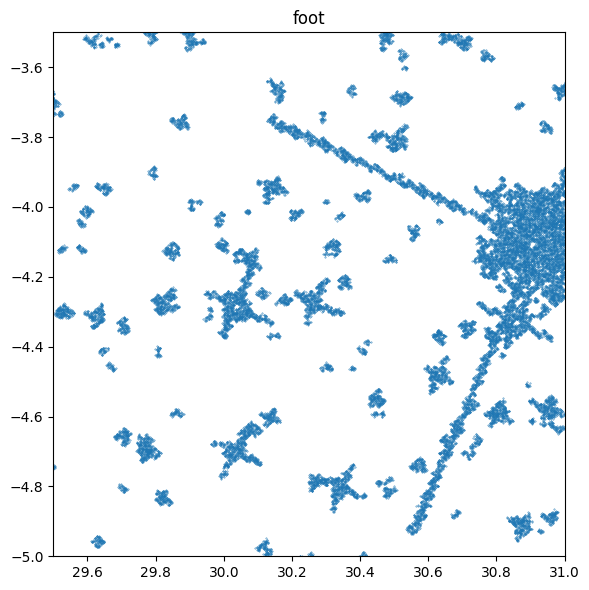

In [30]:
# Plot a region to check rejects
mkw.plot(stage='foot',s=0.1, nr=10_000_000, xwin=[29.5,31], ywin=[-5,-3.5], figsize=[6,6])

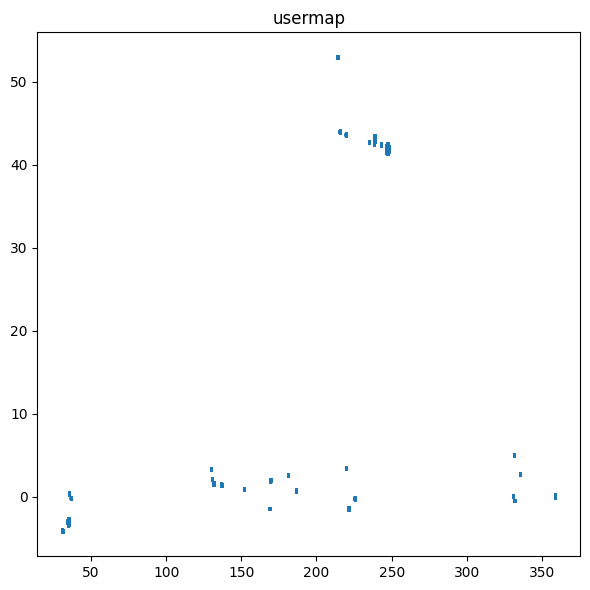

In [31]:
# Plot a region to check verv very bright stars
mkw.plot(stage='usermap',s=0.1, nr=1_000_000,figsize=[6,6])

In [12]:
#mkw.makerans(stage='foot', nr=20_000_000, file='/home/edonoso/incubator/wiseagn/reject_all_randoms.parquet')

As before, create a mask for the moon trails. Upon visual inspection of the AGN C75 catalog, therea are 4 potential trails crossing HSC. First, we get moon_lev column, a 4 character string that quantifies the degree of moon contamination in each band. We convert this moon_lev into an integer and after visual inspection, select only those C75 AGNs with moon_lev>2400. Then, we hats-ingest these into --> /wiseagn/moon2400, and pixelize it into a footprint

In [52]:
order_moon = 8   # initial order for moon_lev pixelization
mkmoon = SkyMaskPipe(order_out=15)  # this order is unused
mkmoon.build_footprint_mask(hatscat='/home/edonoso/incubator/wiseagn/moon2400_hats/', order_foot=order_moon)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating HATS catalog from: /home/edonoso/incubator/wiseagn/moon2400_hats/
    Order :: 8
--- Footprint map area                    : 120.91074076323372


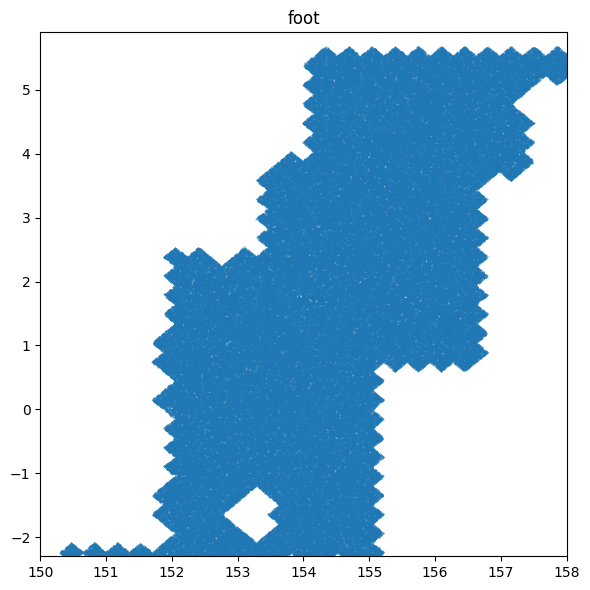

In [53]:
# Plot a moon trail to check
mkmoon.plot(stage='foot',s=0.1, nr=1_000_000,figsize=[6,6],xwin=[150,158],ywin=[-2.3,5.9])

Now work out the HSC optical mask as usual by pixelizing HSC galaxies, apply patch, bright stars, extended galaxies, and combining all into the "mask" stage

In [54]:
order_out = 15   #  ouput order of final combined mask
mkp = SkyMaskPipe(order_out=order_out)
mkp.build_footprint_mask(hatscat=HATSCAT)
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE)
mkp.build_holes_mask(star_regs=STARS_REGIONS, box_regs=BOX_STARS_REGIONS)
mkp.build_extended_mask(ellip_regs=EXT_FILE)
mkp.combine_mask(apply_extendedmap=True)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating HATS catalog from: /srv/shr/public/HSC/hscx_c_gal/
    Order :: 13
--- Footprint map area                    : 1073.2705178720912
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-AEGIS.parquet
    Order :: 13
    Patches with QA                       : 105
    Patches with QA fulfilling conditions : 63
    Surviving patch pixels                : 34064
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-autumn.parquet
    Order :: 13
    Patches with QA                       : 22923
    Patches with QA fulfilling conditions : 8921
    Surviving patch pixels                : 4870749
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-hectomap.parquet
    Order :: 13
    Patches with QA                       : 4524
    Patches with QA fulfilling conditions : 2073
    Surviving patch pixe

After applying the optical mask, we get 675.59 deg2. Now apply the WISE reject mask generate above by (1) upgrading to ouput resolution, (2) setting the reject mask as a holes map, (3) combining into the ouput mask stage

In [59]:
# Upgrade resolution of WISE reject mask (stored as a foot stage in mkw) and place it as a holemap into the (mkp) mask
mkp.holemap = mkw.foot.upgrade(2**order_out)
mkp.order_holes = order_out
# Bring back the HSC mask stage (which has all optical masking) into the footprint stage
mkp.foot = mkp.mask
mkp.order_foot = order_out
# Reapply the new holes map (due to WISE rejects) into a new combined mask stage
mkp.combine_mask(apply_holemap=True, apply_extendedmap=False, apply_patchmap=False, apply_usermap=False)

We get 643.61 deg2, which is is not 675.59 minus WISE_reject_area because many pixels are already masked by the optical part. The net difference is about 32 deg2 of lost area. Now, do the same procedure but to excise the circles around very very bright stars in WISE

In [62]:
# Bring the new mask stage into the footprint stage, bring the user-defined map for very bright artifacts into the holemap, then combine
mkp.foot = mkp.mask
mkp.order_foot = mkp.order_out
mkp.holemap = mkw.usermap
mkp.order_holes = mkw.order_user
mkp.combine_mask(apply_holemap=True, apply_extendedmap=False, apply_patchmap=False, apply_usermap=False)

COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 642.9870961001169


We get 642.98 deg2, which is slightly less than before, so we are not loosing much by enforcing these circles around very very bright stars in WISE. Finally, we apply the same procudure to mask out the moon trails

In [63]:
# Bring the new mask stage into the footprint stage, bring the upscaled moon map into the holemap, then combine
mkp.foot = mkp.mask
mkp.order_foot = mkp.order_out
mkp.holemap = mkmoon.foot.upgrade(2**order_out)
mkp.order_holes = order_out
mkp.combine_mask(apply_holemap=True, apply_extendedmap=False, apply_patchmap=False, apply_usermap=False)

COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 578.1401488699345


With this we get 578.14 deg^2, which is a considerable fraction. We could check correlationw with/without the moon mask to check if there are signicative diferences

## 2. Apply final mask to catalog / save to disk
---------

In [65]:
# Save only the final mask stage to save space
mkp.mask.write('./hscPwise_maskstage.fits', clobber=True)

### Cut HSC in two versions, one only with ra-dec-z (rdz) and another for the full catalog

In [67]:
srcs = lsdb.read_hats(HATSCAT)
srcs.columns

Index(['object_id_UNC', 'g_cmodel_mag_UNC', 'r_cmodel_mag_UNC',
       'isprimary_UNC', 'i_cmodel_mag_UNC', 'z_cmodel_mag_UNC',
       'y_cmodel_mag_UNC', 'g_cmodel_magerr_UNC', 'r_cmodel_magerr_UNC',
       'i_cmodel_magerr_UNC', 'z_cmodel_magerr_UNC', 'y_cmodel_magerr_UNC',
       'i_extendedness_value_UNC', 'ra_UNC', 'dec_UNC', 'object_id', 'ra',
       'dec', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag',
       'y_cmodel_mag', 'g_mag_offset', 'r_mag_offset', 'i_mag_offset',
       'z_mag_offset', 'y_mag_offset', 'corr_rmag', 'corr_imag', 'coord_ra',
       'coord_dec', 'modelfit_CModel_fracDev', 'modelfit_CModel_exp_apCorr',
       '_dist_arcsec', 'photoz_best_pz', 'photoz_conf_best_pz',
       'photoz_risk_best_pz', 'stellar_mass_pz', 'sfr_pz', 'ra_pz', 'dec_pz'],
      dtype='object')

In [68]:
srcs = lsdb.read_hats(HATSCAT, columns=['ra','dec','photoz_best_pz']).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra','dec'], file='masked_hpwm_hscx_c_gal_rdz.parquet')  # (h)HSC (p)plus (w)WISE (m) moon

74428920 sources within mask  written to: masked_hpwm_hscx_c_gal_rdz.parquet


In [69]:
srcs = lsdb.read_hats(HATSCAT).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra','dec'], file='masked_hpwm_hscx_c_gal.parquet')

74428920 sources within mask  written to: masked_hpwm_hscx_c_gal.parquet


### Cut Quaia

In [14]:
QUAIA_PATH = '/home/edonoso/incubator/quaia/quaia_hats/'
srcs = lsdb.read_hats(QUAIA_PATH).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, file='masked_quaia.parquet')

29707 sources within mask  written to: masked_quaia.parquet


### Cut Milliquas

In [6]:
MILLIQ_PATH = '/home/edonoso/incubator/milliquas/milliquas_hats/'
srcs = lsdb.read_hats(MILLIQ_PATH).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['RA','DEC'], file='masked_milliq.parquet')

84116 sources within mask  written to: masked_milliq.parquet


## 3. If needed, load final mask from disk and reconstruct the SkyMaskPipe() object
-----------

In [3]:
import healsparse as hs
from skykatana import SkyMaskPipe

In [4]:
mkp = SkyMaskPipe()
mkp.mask = hs.HealSparseMap.read('./hsc_maskstage.fits')

## 4. Generate randoms
--------------

In [70]:
mkp.makerans(stage='mask', nr=100_000_000, file='/home/edonoso/incubator/wiseagn/hsc_wise_moon_randoms.parquet')  #increase to 100mii

100000000 randoms written to: /home/edonoso/incubator/wiseagn/hsc_wise_moon_randoms.parquet


ra,dec
float64,float64
37.95253872871398,-0.4091181474564674
129.33681070804596,4.015457769147336
333.20116460323334,4.034246146094338
229.19243472696513,43.303720003794986
352.9760885238647,2.096976469605246
34.994679093360894,-2.240435825864842
189.52295780181882,-1.4162108958490787
238.11590688651793,43.93292892469634
19.038716554641724,1.4749327863908301


## 55. Repeat over small window
-----------

In [11]:
%%time 
mkp = SkyMaskPipe(order_out=15)
mkp.build_footprint_mask(hipcat=HIPCAT)
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE)
mkp.build_holes_mask(star_regs=STARS_REGIONS, box_regs=BOX_STARS_REGIONS)
mkp.build_user_mask(poly_uregs=USER_FILE,order_user=15)
mkp.build_extended_mask(ellip_regs=EXT_FILE)
mkp.combine_mask(apply_extendedmap=True, apply_usermap=True)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: /home/edonoso/incubator/hsc/hscx_gal/
    Order :: 13
--- Footprint map area                    : 1073.2705178720912
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-AEGIS.parquet
    Order :: 13
    Patches with QA                       : 105
    Patches with QA fulfilling conditions : 63
    Surviving patch pixels                : 34064
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-autumn.parquet
    Order :: 13
    Patches with QA                       : 22923
    Patches with QA fulfilling conditions : 8921
    Surviving patch pixels                : 4870749
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-hectomap.parquet
    Order :: 13
    Patches with QA                       : 4524
    Patches with QA fulfilling conditions : 2073
    Surviving p

In [12]:
srcs = lsdb.read_hipscat(HIPCAT, columns=['ra_mag','dec_mag','photoz_best_pz']).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra_mag','dec_mag'], file='../hsc_wind/masked_hscx_gal_rdz.parquet')

6072385 sources within mask  written to: ../hsc_wind/masked_hscx_gal_rdz.parquet


In [13]:
srcs = lsdb.read_hipscat(HIPCAT).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra_mag','dec_mag'], file='../hsc_wind/masked_hscx_gal.parquet')

6072385 sources within mask  written to: ../hsc_wind/masked_hscx_gal.parquet


In [12]:
srcs_masked

,object_id_mag,g_cmodel_mag_mag,r_cmodel_mag_mag,isprimary_mag,i_cmodel_mag_mag,z_cmodel_mag_mag,y_cmodel_mag_mag,g_cmodel_magerr_mag,r_cmodel_magerr_mag,i_cmodel_magerr_mag,...,ra_pz,dec_pz,Norder_pz,Dir_pz,Npix_pz,_dist_arcsec,coord_ra_hsc_g,coord_dec_hsc_g,modelfit_CModel_fracDev_hsc_g,modelfit_CModel_exp_apCorr_hsc_g
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
2305843009712816128,42314292678102751,25.993744,24.838945,True,24.384586,24.198912,24.110409,0.114237,0.074718,0.038101,...,225.000881,0.00155,6,0,8192,0.0,225.000881,0.00155,0.0,0.981961
2305843026435506176,42314292678120441,25.454407,25.375757,True,24.822769,24.915205,23.830956,0.063035,0.120412,0.054398,...,225.005229,0.004906,6,0,8192,0.0,225.005229,0.004906,0.0,0.98149
2305843027396001792,42314292678120573,24.520378,24.623102,True,24.364727,23.991539,23.776226,0.03277,0.062693,0.043902,...,225.005192,0.006619,6,0,8192,0.0,225.005192,0.006619,0.840423,0.981772
2305843030600450048,42314292678120657,22.705421,22.263102,True,22.017723,21.926386,21.850037,0.00704,0.007826,0.005237,...,225.004956,0.008803,6,0,8192,0.0,225.004956,0.008803,0.357799,0.982082
2305843036472475648,42314292678120658,26.386303,25.833843,True,25.267677,24.470501,24.207371,0.247588,0.248535,0.139182,...,225.004391,0.009254,6,0,8192,0.0,225.004391,0.009254,1.0,0.982018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682136497533485056,41245601735659447,25.142992,24.697458,True,24.168535,23.993719,24.20698,0.044805,0.058598,0.028078,...,224.997839,-0.012044,6,40000,45055,0.0,224.997839,-0.012044,0.0,0.978126
12682136497885806592,41245601735659445,24.15976,23.375513,True,22.925846,22.496752,22.194336,0.031475,0.02631,0.016646,...,224.999075,-0.011088,6,40000,45055,0.0,224.999075,-0.011088,0.0,0.978248
12682136507339767808,41245601735642430,25.639069,23.825884,True,22.479767,21.984974,21.758823,0.107531,0.044918,0.011295,...,225.007389,-0.008175,6,40000,45055,0.0,225.007389,-0.008175,0.189978,0.979501


In [10]:
mkp.makerans(stage='mask', nr=24_000_000, file='../hsc_wind/rands.fits', clobber=True)

24000000 randoms written to: ../hsc_wind/rands.fits


ra,dec
float64,float64
222.08906292915344,0.23102949799079067
215.31174838542938,0.7336370051060217
222.1291619539261,-1.1610750200317497
214.07948791980743,0.7189190417120525
217.70214378833768,-0.49472130233343764
223.73837471008298,1.3062137922089039
219.78411734104156,1.141145059316776
225.47979354858398,0.20016593098445207
223.38888287544248,2.7803451209303076


## 66. Repeat over small window - no bright no extend
-----------

In [3]:
%%time 
mkp = SkyMaskPipe(order_out=15)
mkp.build_footprint_mask(hipcat=HIPCAT)
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE)
mkp.build_user_mask(poly_uregs=USER_FILE,order_user=15)
mkp.combine_mask(apply_extendedmap=False, apply_holemap=False, apply_usermap=True)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: /home/edonoso/incubator/hsc/hscx_gal/
    Order :: 13
--- Footprint map area                    : 1073.2705178720912
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-AEGIS.parquet
    Order :: 13
    Patches with QA                       : 105
    Patches with QA fulfilling conditions : 63
    Surviving patch pixels                : 34064
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-autumn.parquet
    Order :: 13
    Patches with QA                       : 22923
    Patches with QA fulfilling conditions : 8921
    Surviving patch pixels                : 4870749
--- Processing /home/edonoso/incubator/hsc/hsc_patches/tracts_patches_W-hectomap.parquet
    Order :: 13
    Patches with QA                       : 4524
    Patches with QA fulfilling conditions : 2073
    Surviving p

In [4]:
!pwd

/home/edonoso/incubator/hsc/hsc_mask


In [5]:
srcs = lsdb.read_hipscat(HIPCAT, columns=['ra_mag','dec_mag','photoz_best_pz']).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra_mag','dec_mag'], file='../hsc_wind/maskednoh_hscx_gal_rdz.parquet')

6764539 sources within mask  written to: ../hsc_wind/maskednoh_hscx_gal_rdz.parquet


In [13]:
srcs = lsdb.read_hipscat(HIPCAT).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra_mag','dec_mag'], file='../hsc_wind/masked_hscx_gal.parquet')

6072385 sources within mask  written to: ../hsc_wind/masked_hscx_gal.parquet


In [12]:
srcs_masked

,object_id_mag,g_cmodel_mag_mag,r_cmodel_mag_mag,isprimary_mag,i_cmodel_mag_mag,z_cmodel_mag_mag,y_cmodel_mag_mag,g_cmodel_magerr_mag,r_cmodel_magerr_mag,i_cmodel_magerr_mag,...,ra_pz,dec_pz,Norder_pz,Dir_pz,Npix_pz,_dist_arcsec,coord_ra_hsc_g,coord_dec_hsc_g,modelfit_CModel_fracDev_hsc_g,modelfit_CModel_exp_apCorr_hsc_g
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
2305843009712816128,42314292678102751,25.993744,24.838945,True,24.384586,24.198912,24.110409,0.114237,0.074718,0.038101,...,225.000881,0.00155,6,0,8192,0.0,225.000881,0.00155,0.0,0.981961
2305843026435506176,42314292678120441,25.454407,25.375757,True,24.822769,24.915205,23.830956,0.063035,0.120412,0.054398,...,225.005229,0.004906,6,0,8192,0.0,225.005229,0.004906,0.0,0.98149
2305843027396001792,42314292678120573,24.520378,24.623102,True,24.364727,23.991539,23.776226,0.03277,0.062693,0.043902,...,225.005192,0.006619,6,0,8192,0.0,225.005192,0.006619,0.840423,0.981772
2305843030600450048,42314292678120657,22.705421,22.263102,True,22.017723,21.926386,21.850037,0.00704,0.007826,0.005237,...,225.004956,0.008803,6,0,8192,0.0,225.004956,0.008803,0.357799,0.982082
2305843036472475648,42314292678120658,26.386303,25.833843,True,25.267677,24.470501,24.207371,0.247588,0.248535,0.139182,...,225.004391,0.009254,6,0,8192,0.0,225.004391,0.009254,1.0,0.982018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682136497533485056,41245601735659447,25.142992,24.697458,True,24.168535,23.993719,24.20698,0.044805,0.058598,0.028078,...,224.997839,-0.012044,6,40000,45055,0.0,224.997839,-0.012044,0.0,0.978126
12682136497885806592,41245601735659445,24.15976,23.375513,True,22.925846,22.496752,22.194336,0.031475,0.02631,0.016646,...,224.999075,-0.011088,6,40000,45055,0.0,224.999075,-0.011088,0.0,0.978248
12682136507339767808,41245601735642430,25.639069,23.825884,True,22.479767,21.984974,21.758823,0.107531,0.044918,0.011295,...,225.007389,-0.008175,6,40000,45055,0.0,225.007389,-0.008175,0.189978,0.979501


In [7]:
mkp.makerans(stage='mask', nr=24_000_000, file='../hsc_wind/randsnoh.fits')

24000000 randoms written to: ../hsc_wind/randsnoh.fits


ra,dec
float64,float64
222.50409185886383,1.7114809950996295
219.33355450630188,0.8513233352201969
214.91816103458402,-0.23426703434719215
222.2289401292801,1.5061117663631736
224.27982687950131,1.1731942900057106
221.80439472198486,3.330367362552087
219.29044604301453,-0.29016133660567955
223.1824707984924,-0.4802271162869594
225.52344381809235,-0.2287846244108327
